In [4]:
require(data.table)
require(tidyverse)

## 1. Read data 

In [57]:
dat.mat <- fread('./dat/1901/alpha.promoter.long_matrix.txt')
dat.mat$overlap <- NULL 
#dat.mat$cell <- NULL #no need cell id 

 Concepts: 
1. `promoter region`: -500bp + 500bp for all TSS in gencode 
2. `promoter Peaks`: peaks that overlap promoter region

In [4]:
dat.summary <- list() 
dat.summary$n.unique.gene <- length(unique(dat.mat$gene))
dat.summary$n.promoter.peak <- length(unique(dat.mat$peak))

In [6]:
# get all cells 
dat.all.cells <- fread('./dat/output.umap.ab.filtered.csv')
dat.all.cells <- table(dat.all.cells$cluster) # table for all cells

## 2. Fisher's exact test at Gene level 

As long as there is any promoter peaks in that cell, the gene's promoter is open. 

1. get total alpha 1 and alpha 2 cells 
2. test hit in alpha1 vs hit in alpha2  (create contentigen table)
3. perform [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test) or [chi-squared test](https://en.wikipedia.org/wiki/Chi-squared_test)

### 2.1 Prepare data

In [73]:
# prepare data
dat.mat.gene_level <- dat.mat%>%
    select(-peak)%>%
    distinct()%>%
    select(-cell)
head(dat.mat.gene_level)

gene,cluster,cell
SAMD11,alpha_1,Islet1-fresh_AGACACCTAGGCAGAAGTAAGGAGCAGGA
SAMD11,alpha_1,Islet1-fresh_AGACACCTATGCGCAGCGTCTAATGGTTG
SAMD11,alpha_2,Islet1-fresh_AGACACCTCGAGGCTGAAGGCTATGGTTG
SAMD11,alpha_2,Islet1-fresh_AGACACCTCGTACTAGCTAAGCCTGTACT
SAMD11,alpha_1,Islet1-fresh_AGACACCTGGACTCCTTCGACTAGGGTTG
SAMD11,alpha_2,Islet1-fresh_AGACACCTGGAGCTACAAGGAGTAAGGCG


In [74]:
cat("Check how rows changed:\n") 
cat(sprintf("Before applying uniquness, # of rows:%d\n",nrow(dat.mat)))
cat(sprintf("After applying uniquness, # of rows:%d\n",nrow(dat.mat.gene_level)))


Check how rows changed:
Before applying uniquness, # of rows:8463454
After applying uniquness, # of rows:8236192


### 2.2 check if there are duplicated cell for same gene

In [75]:
test.dat <-dat.mat.gene_level%>% filter (gene=="SAMD11") 
head(test.dat) 

gene,cluster,cell
SAMD11,alpha_1,Islet1-fresh_AGACACCTAGGCAGAAGTAAGGAGCAGGA
SAMD11,alpha_1,Islet1-fresh_AGACACCTATGCGCAGCGTCTAATGGTTG
SAMD11,alpha_2,Islet1-fresh_AGACACCTCGAGGCTGAAGGCTATGGTTG
SAMD11,alpha_2,Islet1-fresh_AGACACCTCGTACTAGCTAAGCCTGTACT
SAMD11,alpha_1,Islet1-fresh_AGACACCTGGACTCCTTCGACTAGGGTTG
SAMD11,alpha_2,Islet1-fresh_AGACACCTGGAGCTACAAGGAGTAAGGCG


In [78]:
# check if there are duplicated cells for the same gene SMAD11 
cat(sprintf("check if there are duplicated cells for the same gene SMAD11:%i",
            !length(unique(test.dat$cell))== nrow(test.dat)))

check if there are duplicated cells for the same gene SMAD11:0

In [103]:
# so remove cell column
#dat.mat.gene_level <- dat.mat.gene_level %>% select(-cell)
sum(is.na(dat.mat.gene_level))

[1] 0

### 2.3 perform fisher's exact test for all genes

In [79]:
all.genes <- unique(dat.mat.gene_level$gene)
cat(sprintf("There are %d unique genes.",length(all.genes)))

There are 15378 unique genes.

In [185]:
fun.ftestPerGene <- function(g="SAMD11"){
    test.dat <-  table(dat.mat.gene_level%>% filter (gene==g)) # table for test dat
    table.res <- as.vector(test.dat)
    names(table.res) <- colnames(test.dat)
    # handle if 0 for one subtype 
    a=setdiff(c("alpha_1","alpha_2"),    names(table.res))
    table.res[a]<-0
    
    test.tab <- matrix(c(table.res["alpha_1"], table.res["alpha_2"], 
                         dat.all.cells[1]-table.res["alpha_1"], dat.all.cells[2]-table.res["alpha_2"]),
                       byrow =  T,       
                       nrow = 2,
                       dimnames = list(expressed = c("Yes", "No"),
                       subtype = c("a1", "a2")))
    test.res <- fisher.test(test.tab)
    res <- list(pval=test.res$p.value/2,
                odds=test.res$estimate,
                type1_frac=test.tab[1]/(test.tab[1]+test.tab[2]),
                type2_frac=test.tab[3]/(test.tab[3]+test.tab[4])
               )
    res
}
#fun.ftestPerGene()
#fun.ftestPerGene(g=all.genes[2])

In [183]:
# time consumming task
if(T){require(parallel)
system.time(res.genes_level.a <- mclapply(all.genes,function(x) fun.ftestPerGene(g = x),mc.cores = 8))}

    user   system  elapsed 
1296.244   47.811  338.486 

In [184]:
res.genes_level.a.df <- do.call(rbind,res.genes_level.a)
rownames(res.genes_level.a.df) <- all.genes
head(res.genes_level.a.df)

,pval,odds,type1_frac,type2_frac
SAMD11,1.966667e-06,0.5327304,0.03984998,0.07228916
NOC2L,0.1934535,0.8726655,0.0403188,0.04593373
KLHL17,0.2498725,0.8278814,0.01312705,0.01581325
PLEKHN1,0.000104741,0.43971,0.01312705,0.02936747
C1orf170,0.2911566,1.227541,0.01383029,0.01129518
HES4,6.476127e-28,0.2463542,0.02930145,0.1091867


In [293]:
# adjust for p value 
m<- c("fdr","bonferroni","BY");names(m)<-c("FDR","padj.Bonferroni","FDR.BY")
res.genes_level.a.df <- as.data.frame(res.genes_level.a.df)
for(i in 1:3){
    res.genes_level.a.df[[names(m)[i]]] <- p.adjust(as.numeric(res.genes_level.a.df$pval),method = m[i])
}
res.genes_level.a.df$odds <- as.numeric(res.genes_level.a.df$odds)
head(res.genes_level.a.df)
fwrite(res.genes_level.a.df,"./dat/1901/res.genes_level.a.csv",row.names = T)

,pval,odds,type1_frac,type2_frac,FDR,padj.Bonferroni,FDR.BY
SAMD11,1.966667e-06,0.5327304,0.03984998,0.07228916,1.338796e-05,3.024340e-02,1.367974e-04
NOC2L,0.1934535,0.8726655,0.0403188,0.04593373,2.451277e-01,1.000000e+00,1.000000e+00
KLHL17,0.2498725,0.8278814,0.01312705,0.01581325,2.996132e-01,1.000000e+00,1.000000e+00
PLEKHN1,0.000104741,0.4397100,0.01312705,0.02936747,4.191277e-04,1.000000e+00,4.282622e-03
C1orf170,0.2911566,1.2275406,0.01383029,0.01129518,3.380598e-01,1.000000e+00,1.000000e+00
HES4,6.476127e-28,0.2463542,0.02930145,0.1091867,9.958989e-25,9.958989e-24,1.017604e-23


In [7]:
res.genes_level.a.df <- fread('./dat/1901/res.genes_level.a.csv')%>%
    as.data.frame()%>%
    column_to_rownames('V1')
head(res.genes_level.a.df)

,pval,odds,type1_frac,type2_frac,FDR,padj.Bonferroni,FDR.BY
SAMD11,1.966667e-06,0.5327304,0.03984998,0.07228916,1.338796e-05,3.024340e-02,1.367974e-04
NOC2L,1.934535e-01,0.8726655,0.04031880,0.04593373,2.451277e-01,1.000000e+00,1.000000e+00
KLHL17,2.498725e-01,0.8278814,0.01312705,0.01581325,2.996132e-01,1.000000e+00,1.000000e+00
PLEKHN1,1.047410e-04,0.4397100,0.01312705,0.02936747,4.191277e-04,1.000000e+00,4.282622e-03
C1orf170,2.911566e-01,1.2275406,0.01383029,0.01129518,3.380598e-01,1.000000e+00,1.000000e+00
HES4,6.476127e-28,0.2463542,0.02930145,0.10918675,9.958989e-25,9.958989e-24,1.017604e-23


### 2.4 Plot and explore the results 

In [292]:
range(log10(res.genes_level.a.df$padj.Bonferroni))
#sum(is.infinite(as.numeric(res.genes_level.a.df$odds)))
range((res.genes_level.a.df%>% gather(key="subtype",value = "frac",3:4))$frac)

[1] -33.77742   0.00000

[1] 0.0000000 0.5572289

#### 2.4.1 Determine fraction threhsolds 

In [20]:
pd<- res.genes_level.a.df%>% gather(key="subtype",value = "frac",3:4)
cat('padj.Bonferroni:\n')
cat('- alpha1:')
cat(sum(res.genes_level.a.df$padj.Bonferroni <0.01 & log2(res.genes_level.a.df$odds)>1))
cat('\n')
cat('- alpha2:')
cat(sum(res.genes_level.a.df$padj.Bonferroni <0.01 & log2(res.genes_level.a.df$odds)< -1))


padj.Bonferroni:
- alpha1:46
- alpha2:494

In [22]:
pd<- res.genes_level.a.df%>% gather(key="subtype",value = "frac",3:4)
cat('FDR:\n')
cat('- alpha1:')
cat(sum(res.genes_level.a.df$FDR <0.01 & log2(res.genes_level.a.df$odds)>1))
cat('\n')
cat('- alpha2:')
cat(sum(res.genes_level.a.df$FDR <0.01 & log2(res.genes_level.a.df$odds)< -1))


FDR:
- alpha1:270
- alpha2:756

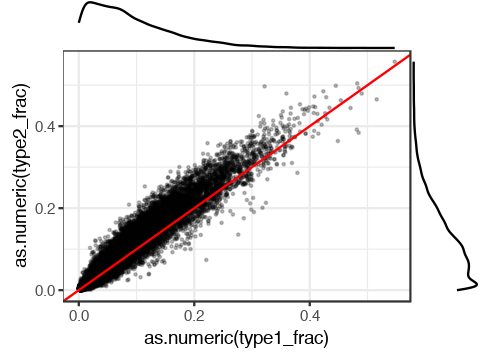

In [327]:
options(repr.plot.width=4, repr.plot.height=3)
require(ggExtra)
p <- ggplot(res.genes_level.a.df, aes(as.numeric(type1_frac),
                                      as.numeric(type2_frac))) +
    geom_point(alpha=.25,size=.25) + theme_bw()+
    geom_abline(slope = 1,intercept = 0,color='red')
# add marginal histograms
ggExtra::ggMarginal(p, type = "density")

#### 2.4.2 Volcano plot

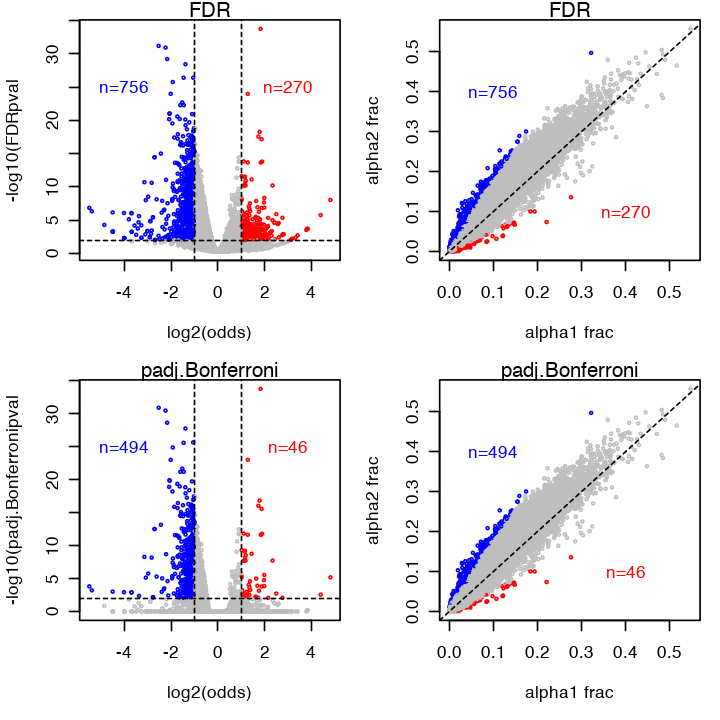

In [29]:
require(ggplot2)
options(repr.plot.width=6, repr.plot.height=6)
require(LSD)
par(mar=c(5,4,1,1),mfrow = c(2,2))
for(m in c("FDR","padj.Bonferroni")){
    up<- res.genes_level.a.df[,m] <0.01 & log2(res.genes_level.a.df$odds)>1
    down<-res.genes_level.a.df[,m] <0.01 & log2(res.genes_level.a.df$odds)< -1
plot(x=log2(res.genes_level.a.df$odds),y=-log10(as.numeric(res.genes_level.a.df[,m])),
     xlab = "log2(odds)",ylab=paste0('-lbog10(',m,'pval'),cex=.25,
     col=ifelse(up,"red",ifelse(down,"blue","grey")),
     main = m)
abline(h = 2,col=1,lty=2)
abline(v=c(-1,1),col=1,lty=2)
text(-4,25,col='blue',labels = paste0("n=",sum(down)))
text(3,25,col='red',labels = paste0("n=",sum(up)))

# scatter 
plot(x=as.numeric(res.genes_level.a.df$type1_frac),y=as.numeric(res.genes_level.a.df$type2_frac),
     xlab = "alpha1 frac",ylab='alpha2 frac',cex=.25,
     col=ifelse(up,"red",ifelse(down,"blue","grey")),
     main = m)
abline(a=0,b = 1,col=1,lty=2)
text(.1,.4,col='blue',labels = paste0("n=",sum(down)))
text(.4,.1,col='red',labels = paste0("n=",sum(up)))
}



# MAplot
if(F){
    plot(y=log2(res.genes_level.a.df$odds),x=as.numeric(res.genes_level.a.df$type1_frac),
            ylab = "log2(odds)",xlab='apha1 frac',cex=.25,col='grey',pch=16,
            main = '')

    abline(h = c(-1,1),col=2,lty=2)

}

#ggplot(res.genes_level.a.df,aes(odds,-log10(FDR)))+geom_point()

### 2.5 GOterm analysis

In [32]:
require(enrichR)
alpha.glist <- list()
m<-"padj.Bonferroni"
    up<- res.genes_level.a.df[,m] <0.01 & log2(res.genes_level.a.df$odds)>1
    down<-res.genes_level.a.df[,m] <0.01 & log2(res.genes_level.a.df$odds)< -1

    alpha.glist$alpha1<- rownames(res.genes_level.a.df)[up]
    alpha.glist$alpha2<- rownames(res.genes_level.a.df)[down]
    dbs<- c("GO_Biological_Process_2018","KEGG_2018")
    enriched <- enrichr(alpha.glist$alpha1, dbs)
    go.res.a <- list()
    go.res.a$alpha_1 <- enriched
    enriched[["GO_Biological_Process_2018"]]%>% 
        filter(Adjusted.P.value<0.1)%>%
        arrange(Adjusted.P.value)%>% 
        select(-starts_with("old"))
    


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
  Querying KEGG_2018... Done.
Parsing results... Done.


Term,Overlap,P.value,Adjusted.P.value,Z.score,Combined.Score,Genes
regulation of insulin secretion (GO:0050796),4/99,7.857889e-05,0.02239498,-1.299263,12.27987,SLC30A8;ABCC8;GCG;KCNA5
positive regulation of cation transmembrane transport (GO:1904064),2/18,7.734545e-04,0.07347818,-2.088455,14.96304,AKAP6;PDZK1
regulation of peptide hormone secretion (GO:0090276),3/74,6.583933e-04,0.07347818,-1.842008,13.49401,ABCC8;GCG;KCNA5


In [42]:
dbs <- listEnrichrDbs()
dbs%>%filter(grepl("Biological_Process",libraryName))

libraryName,numTerms,geneCoverage,genesPerTerm,link
GO_Biological_Process_2015,5192,14264,58,http://www.geneontology.org/GO.downloads.annotations.shtml
GO_Biological_Process_2013,941,7682,78,http://www.geneontology.org/GO.downloads.annotations.shtml
GO_Biological_Process_2017,3166,13822,21,http://www.geneontology.org/
GO_Biological_Process_2017b,10125,13247,49,http://www.geneontology.org/
GO_Biological_Process_2018,5103,14433,36,http://www.geneontology.org/


In [34]:
    enriched <- enrichr(alpha.glist$alpha2, dbs)
go.res.a$alpha2 <- enriched
enriched[["GO_Biological_Process_2018"]]%>% 
    filter(Adjusted.P.value<0.1)%>%
    arrange(Adjusted.P.value)%>% 
    select(-starts_with("old"))

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
  Querying KEGG_2018... Done.
Parsing results... Done.


Term,Overlap,P.value,Adjusted.P.value,Z.score,Combined.Score,Genes
"regulation of transcription, DNA-templated (GO:0006355)",67/1599,1.362278e-05,0.02829562,-1.839025,20.604013,RNF10;GMEB2;SMARCB1;HP1BP3;CBY1;YBX1;GPATCH3;UBE2L3;PSMD9;ZNF609;TRIM28;ZNF84;ATXN7L3;PITX3;NCOA1;SMARCC1;ZHX2;TGIF2;FOXD1;SFMBT1;POU3F1;MED26;NPAS4;KARS;MED20;TERF2IP;MAPRE3;ATF3;JDP2;ZNF674;CREB5;KHDRBS1;CASZ1;ZNF274;MYCBP;FOXK2;LIN9;RELA;DEDD2;PHF21B;ZNHIT3;NUP85;CCDC85B;TP53INP2;DVL1;UBN1;ZNF623;ZIM2;POLR2L;BRD4;XRCC6;UBE2I;HMGA1;FOXJ1;DEK;INHBA;HNRNPAB;TBX3;FOSL2;NFKB2;FOSL1;CENPF;CNOT7;FUBP3;SNAI1;FOSB;QRICH1
nucleosome organization (GO:0034728),10/80,2.702542e-05,0.02829562,-1.906513,20.054098,HIST1H2BN;SMARCC1;PBRM1;SMARCB1;HIST3H2A;HIST1H2BJ;H2AFX;HIST1H2BK;HMGA1;HIST3H2BB
chromatin disassembly (GO:0031498),5/20,1.027367e-04,0.03585511,-2.080707,19.107845,SMARCC1;PBRM1;SMARCB1;HIST3H2A;HMGA1
nucleosome disassembly (GO:0006337),5/20,1.027367e-04,0.03585511,-2.080195,19.103136,SMARCC1;PBRM1;SMARCB1;HIST3H2A;HMGA1
tumor necrosis factor-mediated signaling pathway (GO:0033209),12/124,5.873930e-05,0.03585511,-1.275645,12.427848,PSMD9;PSMD12;PSMA3;KARS;UBB;TNFRSF12A;TRAF3;PSMD3;TNFSF9;PSMD1;RELT;RELA
gene expression (GO:0010467),24/412,1.006485e-04,0.03585511,-1.255709,11.557391,NCOA1;SMG1;GTF3C4;NXT1;NUP188;RPLP0;DHPS;PWP1;MRPL10;MRPL43;DEDD2;MRPL41;ALKBH5;FUBP3;NUP85;NUP50;EEF1A2;MED20;SRSF2;BUD13;STUB1;RPL19;AGFG1;POLR2L
protein-DNA complex disassembly (GO:0032986),5/22,1.675227e-04,0.03990663,-2.029956,17.649228,SMARCC1;PBRM1;SMARCB1;HIST3H2A;HMGA1
"positive regulation of transcription, DNA-templated (GO:0045893)",48/1121,1.504437e-04,0.03990663,-1.706321,15.018904,RNF10;NFAT5;CASZ1;SMARCB1;PTPRN;SRF;FOXK2;YBX1;GPATCH3;TRIAP1;RELA;RELB;PSMD9;ZNF609;TRIM28;UBB;NUP85;TP53INP2;DVL1;HSF1;LEO1;ATXN7L3;BRD4;PITX3;KDM6B;NCOA1;ZBTB17;SMARCC1;XRCC6;ECD;HMGA1;FOXJ1;EBF4;INHBA;POU3F1;HNRNPAB;FOSL2;NFKB2;NPAS4;FOSL1;MAVS;FUBP3;KARS;GPRIN1;SNAI1;MAPRE3;ATF3;CREB5
NIK/NF-kappaB signaling (GO:0038061),9/81,1.715185e-04,0.03990663,-1.370136,11.880204,PSMD9;PSMD12;PSMA3;UBB;PSMD3;PSMD1;RELA;RELB;NFKB2
regulation of type I interferon production (GO:0032479),9/86,2.712072e-04,0.05679080,-1.316079,10.808464,MAVS;XRCC6;UBB;TRAF3;POLR3E;GPATCH3;RELA;POLR2L;NFKB2


In [348]:
save(file = './dat/1901/res.genes.a.all.rdata',list = c("go.res.a","alpha.glist"))